<a href="https://colab.research.google.com/github/hscrown/bigdata/blob/main/04_2_%ED%99%95%EB%A5%A0%EC%A0%81_%EA%B2%BD%EC%82%AC_%ED%95%98%EA%B0%95%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 확률적 경사 하강법
훈련 세트에서 샘플 하나씩 꺼내 손실함수의 경사를 따라 최적의 모델을 찾는 알고리즘.
<br> 확률적 -> 랜덤으로 샘플을 꺼내는 것
<br>
- 미니 배치 경사하강법 (샘플을 하나씩이 아닌 여러 개 사용)
- 배치 경사 하강법 (한번에 전체 샘플 사용)

### 손실함수
- 확률적 경사 하강법이 최적화 할 대상
- 문제에 맞는 손실함수들이 정의되어 있음
    - 이진 분류 : 로지스틱 회귀 손실 함수 (=이진 크로스 엔트로피 손실함수)
    - 다중 분류 : 크로스엔트로피 손실 함수
    - 회귀 : 평균 제곱 오차 손실 함수
    

#### 데이터 로드 및 전처리

In [1]:
import pandas as pd
fish = pd.read_csv("http://bit.ly/fish_csv_data")

In [2]:
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [3]:
fish.columns

Index(['Species', 'Weight', 'Length', 'Diagonal', 'Height', 'Width'], dtype='object')

In [9]:
import numpy as np
# 특성 데이터
fish_input = fish[['Weight', 'Length', 'Diagonal', 'Height', 'Width']].to_numpy() # 입력데이터는 [] 이거 이중으로 써서 2차원 배열로 만들기

In [10]:
# 타겟 데이터
fish_target = fish['Species'].to_numpy()

In [11]:
## 트레인 테스트 스플릿
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(119, 5) (119,)
(40, 5) (40,)


In [13]:
## z-score 정규화
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

### SGD Classifier

In [18]:
sc = SGDClassifier(loss='log_loss', max_iter=10, random_state=42)
#  SGDClassifier 객체를 생성
# loss='log_loss'는 로지스틱 회귀를 사용하겠다는 뜻
# max_iter=10은 경사 하강법을 최대 10번 반복하여 학습하겠다는 설정
# random_state=42는 결과를 재현할 수 있도록 고정된 난수값을 사용
sc.fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.773109243697479
0.775


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


#### LogisticRegression()과 SGDClassifier(loss='log_loss') 차이
<br> 모델의 본질은 같지만, 최적화 방식(배치 경사 하강법 vs 확률적 경사 하강법)서 차이
<br>LogisticRegression()도 LogisticRegression(solver='saga')는 saga 알고리즘을 사용하여 SGD 방식으로 학습
- 데이터셋이 매우 클 때 배치 경사 하강법보다 훨씬 빠르게 학습 가능
- 다양한 **손실 함수(loss function)**와 옵티마이저(예: log_loss, hinge, squared_hinge 등)를 지원해. 이는 다양한 문제 유형에 맞게 쉽게 적용할 수 있음


In [20]:
# SGDClassifier의 partial_fit 메서드
##  온라인 학습(online learning) 또는 **점진적 학습(incremental learning)**에 사용
## 훈련 데이터를 한 번에 모두 처리하는 것이 아니라 배치 단위로 조금씩 학습할 수 있게
sc.partial_fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.7983193277310925
0.775


### 에포크와 과대/과소적합

In [24]:
# NumPy 라이브러리 임포트 (배열 처리를 위한 라이브러리)
import numpy as np

# SGDClassifier 모델을 생성
# 'log_loss'는 로지스틱 회귀에 사용할 손실 함수
# random_state=42는 결과를 반복할 수 있게 해줌 (결과를 고정시키는 역할)
sc = SGDClassifier(loss='log_loss', random_state=42)

# 훈련 데이터와 테스트 데이터에 대한 정확도를 저장할 리스트 초기화
train_score = []  # 훈련 데이터 정확도 저장 리스트
test_score = []   # 테스트 데이터 정확도 저장 리스트

# train_target에서 고유한 클래스 값을 찾아서 저장
# 각 클래스의 값이 무엇인지 알려줍니다. 예를 들어, 0, 1, 2 같은 값들
classes = np.unique(train_target)

# 모델을 300번 학습시킴
# 이 루프는 모델을 계속해서 점진적으로 학습시켜
for _ in range(0, 300):
    # partial_fit을 사용하여 모델을 점진적으로 학습
    # 이 방식은 대규모 데이터셋에서 유용하고, 데이터를 한 번에 처리하지 않고 조금씩 학습할 수 있게 해줌
    # classes=classes는 다중 클래스 문제에서 각 클래스가 무엇인지 알려줌
    sc.partial_fit(train_scaled, train_target, classes=classes)

    # 학습된 모델을 훈련 데이터로 평가하고 정확도를 리스트에 저장
    # 훈련 데이터에 대해 얼마나 잘 예측하는지 확인
    train_score.append(sc.score(train_scaled, train_target))

    # 학습된 모델을 테스트 데이터로 평가하고 정확도를 리스트에 저장
    # 테스트 데이터는 모델이 실제로 얼마나 잘 일반화되었는지 확인하는 데 사용
    test_score.append(sc.score(test_scaled, test_target))

# 설명:
# - `fit()` 함수는 전체 훈련 데이터를 한 번에 처리하여 모델을 학습시키는 함수로,
#   한 번 실행하면 **1 에포크**가 도는 것과 같다.
#   예를 들어, `model.fit(X_train, y_train)`은 전체 데이터를 한 번에 학습하므로 1 에포크를 도는 것과 같다.
# - `partial_fit()` 함수는 **점진적 학습**을 위한 함수로, 데이터를 조금씩 배치 단위로 처리하면서 학습을 진행한다.
#   따라서 `partial_fit()`은 여러 번 호출되어야 전체 데이터셋을 학습할 수 있다.
#   이 방식은 **대규모 데이터셋**에서 효율적이고 **온라인 학습**(incremental learning)에도 유리하다.
#   각 호출은 **미니 배치 학습**처럼 동작하여 점진적으로 모델을 업데이트할 수 있다.


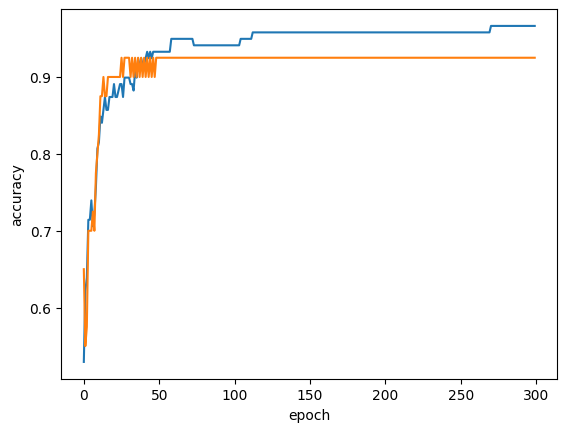

In [25]:
## 시각화
import matplotlib.pyplot as plt

plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

경사 하강법(Gradient Descent)을 사용하면 특성의 크기에 예민해지기 때문에
스케일링이 필요해짐. 상대적으로 LinearRegression(선형회귀)는 표준화 같은 전처리를 안해도 잘 동작함.